In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


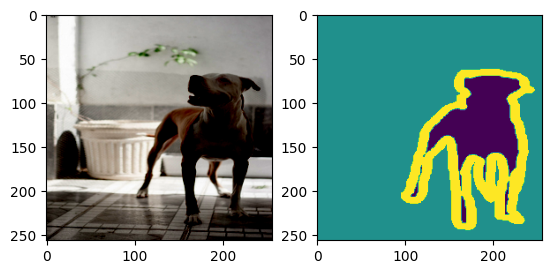

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(3, 3, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [13]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            F.one_hot(train_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask.squeeze(1))
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                F.one_hot(valid_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 0 - TrainLoss: 1.1620914524999157 - ValidLoss: 0.9806445837020874


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.86it/s]


Epoch: 1 - TrainLoss: 0.8464920376909191 - ValidLoss: 0.8644002079963684


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch: 2 - TrainLoss: 0.7018262661736587 - ValidLoss: 0.6077818274497986


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.87it/s]


Epoch: 3 - TrainLoss: 0.6265192350436901 - ValidLoss: 0.6661841869354248


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Epoch: 4 - TrainLoss: 0.583062455571931 - ValidLoss: 0.5883411765098572


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch: 5 - TrainLoss: 0.5433848443730124 - ValidLoss: 0.47653329372406006


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.12it/s]


Epoch: 6 - TrainLoss: 0.5173321715716658 - ValidLoss: 0.6046843528747559


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch: 7 - TrainLoss: 0.5024134799324232 - ValidLoss: 0.4356066584587097


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.72it/s]


Epoch: 8 - TrainLoss: 0.478264090316049 - ValidLoss: 0.49985232949256897


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.76it/s]


Epoch: 9 - TrainLoss: 0.46241054093015604 - ValidLoss: 0.39485472440719604


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch: 10 - TrainLoss: 0.448745835957856 - ValidLoss: 0.505942165851593


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.85it/s]


Epoch: 11 - TrainLoss: 0.43050701710684547 - ValidLoss: 0.39602038264274597


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.86it/s]


Epoch: 12 - TrainLoss: 0.42254302727765053 - ValidLoss: 0.38797610998153687


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.88it/s]


Epoch: 13 - TrainLoss: 0.4029728266699561 - ValidLoss: 0.45414820313453674


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch: 14 - TrainLoss: 0.39098023597536413 - ValidLoss: 0.43991729617118835


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.80it/s]


Epoch: 15 - TrainLoss: 0.3796862831403469 - ValidLoss: 0.3710036873817444


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.88it/s]


Epoch: 16 - TrainLoss: 0.366311753104473 - ValidLoss: 0.3179001212120056


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch: 17 - TrainLoss: 0.3528846635900695 - ValidLoss: 0.3076959550380707


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.86it/s]


Epoch: 18 - TrainLoss: 0.3459125870260699 - ValidLoss: 0.4386644661426544


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 19 - TrainLoss: 0.338100772993318 - ValidLoss: 0.38026028871536255


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.88it/s]


Epoch: 20 - TrainLoss: 0.31645295537751295 - ValidLoss: 0.29512715339660645


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch: 21 - TrainLoss: 0.3115989997469146 - ValidLoss: 0.28077855706214905


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.92it/s]


Epoch: 22 - TrainLoss: 0.29010178662579633 - ValidLoss: 0.329375684261322


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.80it/s]


Epoch: 23 - TrainLoss: 0.28716845116738615 - ValidLoss: 0.2524823546409607


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.88it/s]


Epoch: 24 - TrainLoss: 0.27699970916427413 - ValidLoss: 0.28261643648147583


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.94it/s]


Epoch: 25 - TrainLoss: 0.2767913680652092 - ValidLoss: 0.2590025067329407


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.04it/s]


Epoch: 26 - TrainLoss: 0.27068346096523876 - ValidLoss: 0.3134665787220001


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.87it/s]


Epoch: 27 - TrainLoss: 0.24853248740064687 - ValidLoss: 0.2154988795518875


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.70it/s]


Epoch: 28 - TrainLoss: 0.24666339056245212 - ValidLoss: 0.2364366501569748


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.42it/s]


Epoch: 29 - TrainLoss: 0.256935975161092 - ValidLoss: 0.3308722972869873


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 30 - TrainLoss: 0.2449600786484521 - ValidLoss: 0.23116205632686615


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.86it/s]


Epoch: 31 - TrainLoss: 0.22319526019795188 - ValidLoss: 0.23815344274044037


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 32 - TrainLoss: 0.21549760344727287 - ValidLoss: 0.20041440427303314


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 33 - TrainLoss: 0.20776523829534135 - ValidLoss: 0.1823803186416626


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch: 34 - TrainLoss: 0.20423219250193958 - ValidLoss: 0.20333585143089294


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 35 - TrainLoss: 0.20223161860786634 - ValidLoss: 0.18134596943855286


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 36 - TrainLoss: 0.19849647992643818 - ValidLoss: 0.18782004714012146


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 37 - TrainLoss: 0.19315839610223112 - ValidLoss: 0.2130698710680008


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.53it/s]


Epoch: 38 - TrainLoss: 0.1891594498321928 - ValidLoss: 0.18634513020515442


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.37it/s]


Epoch: 39 - TrainLoss: 0.18639279208306608 - ValidLoss: 0.1965138167142868


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch: 40 - TrainLoss: 0.17752281730544978 - ValidLoss: 0.16266734898090363


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch: 41 - TrainLoss: 0.17473598004415117 - ValidLoss: 0.1882505863904953


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.79it/s]


Epoch: 42 - TrainLoss: 0.169487444491222 - ValidLoss: 0.1561606377363205


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch: 43 - TrainLoss: 0.16358630487631107 - ValidLoss: 0.16617828607559204


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.85it/s]


Epoch: 44 - TrainLoss: 0.15872768929292416 - ValidLoss: 0.17119762301445007


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.85it/s]


Epoch: 45 - TrainLoss: 0.1550416165384753 - ValidLoss: 0.15717166662216187


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.89it/s]


Epoch: 46 - TrainLoss: 0.15181794531386475 - ValidLoss: 0.15957054495811462


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.88it/s]


Epoch: 47 - TrainLoss: 0.14870851897987827 - ValidLoss: 0.1579321324825287


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.87it/s]


Epoch: 48 - TrainLoss: 0.14599430740907274 - ValidLoss: 0.1415184587240219


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch: 49 - TrainLoss: 0.13861395932477097 - ValidLoss: 0.13420838117599487


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 50 - TrainLoss: 0.13714128475764703 - ValidLoss: 0.1432466208934784


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 51 - TrainLoss: 0.13339217842139048 - ValidLoss: 0.11937490105628967


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.77it/s]


Epoch: 52 - TrainLoss: 0.12899505167171874 - ValidLoss: 0.13044488430023193


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.93it/s]


Epoch: 53 - TrainLoss: 0.1268790011005155 - ValidLoss: 0.13233637809753418


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.95it/s]


Epoch: 54 - TrainLoss: 0.124530753570384 - ValidLoss: 0.12754401564598083


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.87it/s]


Epoch: 55 - TrainLoss: 0.12114179879426956 - ValidLoss: 0.11646241694688797


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.80it/s]


Epoch: 56 - TrainLoss: 0.11792344895416293 - ValidLoss: 0.1223675087094307


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.86it/s]


Epoch: 57 - TrainLoss: 0.11800476651767204 - ValidLoss: 0.11375675350427628


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.85it/s]


Epoch: 58 - TrainLoss: 0.11376344785094261 - ValidLoss: 0.11635906994342804


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.67it/s]


Epoch: 59 - TrainLoss: 0.11043099185516095 - ValidLoss: 0.11196625232696533


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.21it/s]


Epoch: 60 - TrainLoss: 0.10665094608376766 - ValidLoss: 0.13211843371391296


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 61 - TrainLoss: 0.10475306212902069 - ValidLoss: 0.10695578157901764


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.77it/s]


Epoch: 62 - TrainLoss: 0.10223750269104695 - ValidLoss: 0.09896156936883926


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 63 - TrainLoss: 0.09953068389460959 - ValidLoss: 0.09648485481739044


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.89it/s]


Epoch: 64 - TrainLoss: 0.09843647544240129 - ValidLoss: 0.09546295553445816


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.76it/s]


Epoch: 65 - TrainLoss: 0.09477668178492579 - ValidLoss: 0.09187997132539749


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.73it/s]


Epoch: 66 - TrainLoss: 0.09305171784141968 - ValidLoss: 0.09501086175441742


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.75it/s]


Epoch: 67 - TrainLoss: 0.09215134086793866 - ValidLoss: 0.09243425726890564


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 68 - TrainLoss: 0.0906037855251082 - ValidLoss: 0.09549850225448608


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 69 - TrainLoss: 0.0885874460740336 - ValidLoss: 0.09121284633874893


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.81it/s]


Epoch: 70 - TrainLoss: 0.08730739483545566 - ValidLoss: 0.08912833034992218


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.73it/s]


Epoch: 71 - TrainLoss: 0.08582708457934446 - ValidLoss: 0.09476060420274734


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.81it/s]


Epoch: 72 - TrainLoss: 0.0850011278586141 - ValidLoss: 0.0894305408000946


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch: 73 - TrainLoss: 0.08331891213511598 - ValidLoss: 0.08468537032604218


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 74 - TrainLoss: 0.08201309434812644 - ValidLoss: 0.08297957479953766


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 75 - TrainLoss: 0.0810458089770942 - ValidLoss: 0.08136924356222153


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 76 - TrainLoss: 0.0797046822463644 - ValidLoss: 0.07748095691204071


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.95it/s]


Epoch: 77 - TrainLoss: 0.07834827193412287 - ValidLoss: 0.07145754992961884


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.89it/s]


Epoch: 78 - TrainLoss: 0.07751947166077022 - ValidLoss: 0.08062798529863358


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.81it/s]


Epoch: 79 - TrainLoss: 0.07715737511371744 - ValidLoss: 0.08893346786499023


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 80 - TrainLoss: 0.07671224929649255 - ValidLoss: 0.07592666149139404


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.91it/s]


Epoch: 81 - TrainLoss: 0.07571349935284977 - ValidLoss: 0.08337360620498657


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 82 - TrainLoss: 0.07553417081462926 - ValidLoss: 0.07848063111305237


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.89it/s]


Epoch: 83 - TrainLoss: 0.07441559254095473 - ValidLoss: 0.07605849951505661


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 84 - TrainLoss: 0.0737033912847782 - ValidLoss: 0.07047644257545471


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 85 - TrainLoss: 0.07354172332019641 - ValidLoss: 0.06855346262454987


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.90it/s]


Epoch: 86 - TrainLoss: 0.07271083405819433 - ValidLoss: 0.07698603719472885


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch: 87 - TrainLoss: 0.07240275422046924 - ValidLoss: 0.07294610142707825


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.87it/s]


Epoch: 88 - TrainLoss: 0.0718150950711349 - ValidLoss: 0.07929441332817078


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.85it/s]


Epoch: 89 - TrainLoss: 0.0717579638906594 - ValidLoss: 0.07263075560331345


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 90 - TrainLoss: 0.07183477770665596 - ValidLoss: 0.07588066905736923


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.89it/s]


Epoch: 91 - TrainLoss: 0.07087134364350088 - ValidLoss: 0.07303492724895477


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 92 - TrainLoss: 0.0711577898212548 - ValidLoss: 0.08374061435461044


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.98it/s]


Epoch: 93 - TrainLoss: 0.07093043060138307 - ValidLoss: 0.07802628725767136


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch: 94 - TrainLoss: 0.07065016699248347 - ValidLoss: 0.07618288695812225


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.80it/s]


Epoch: 95 - TrainLoss: 0.07057562329131982 - ValidLoss: 0.06787770986557007


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.87it/s]


Epoch: 96 - TrainLoss: 0.07011032515558703 - ValidLoss: 0.07629452645778656


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch: 97 - TrainLoss: 0.0703777832717731 - ValidLoss: 0.07163749635219574


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.80it/s]


Epoch: 98 - TrainLoss: 0.07029004806074603 - ValidLoss: 0.06675593554973602


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.98it/s]

Epoch: 99 - TrainLoss: 0.0701108709748449 - ValidLoss: 0.08048141002655029


<All keys matched successfully>

  0%|                                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|██████████████▏                                                        | 2/10 [00:00<00:00, 15.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

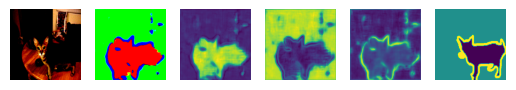

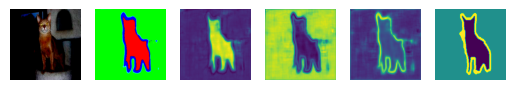

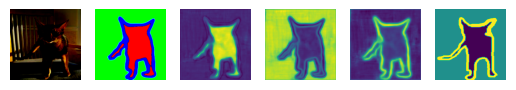

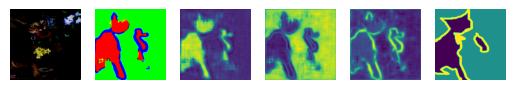

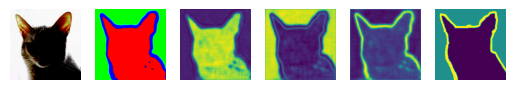

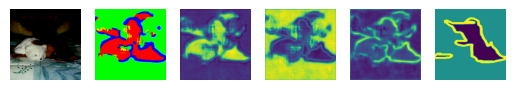

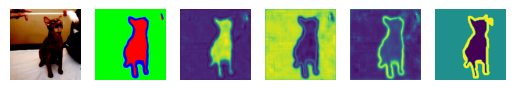

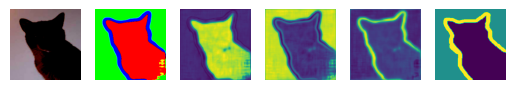

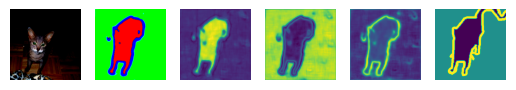

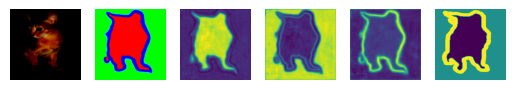

In [15]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')